# ARF: COMPTE RENDU
### de Toldi Melchior, de Bézenac Emmanuel

Pour ce compte rendu, nous allons nous évaluer les modèles vus en TME sur des problèmes de classification binaire. Nous utilisons les données proposés par le site kaggle.com, disponibles à partir du lieu suivant:

https://www.kaggle.com/c/titanic/data

### CHARGEMENT DES DONNÉES

In [93]:
import pandas as pd
path='data/'
train_df=pd.read_csv(path+'final_train.csv',index_col=False)
test_df=pd.read_csv(path+'final_test.csv')
datax=train_df[['Pclass','Age','Parch','Fare','Embarked','Gender']].values
datay=train_df['Survived'].values

print(train_df.shape,test_df.shape)
train_df[:10]

((891, 8), (418, 7))


Survived  Pclass  Age  SibSp  Parch     Fare  Embarked  Gender
0         0       3   22      1      0   7.2500         2       1
1         1       1   38      1      0  71.2833         0       0
2         1       3   26      0      0   7.9250         2       0
3         1       1   35      1      0  53.1000         2       0
4         0       3   35      0      0   8.0500         2       1
5         0       3   28      0      0   8.4583         1       1
6         0       1   54      0      0  51.8625         2       1
7         0       3    2      3      1  21.0750         2       1
8         1       3   27      0      2  11.1333         2       0
9         1       2   14      1      0  30.0708         0       0

### CLASSE CLASSIFIER ET VALIDATION CROISÉE

In [457]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import namedtuple
import numpy as np

class Classifier(object):
    """ Classe generique d'un classifieur
        Dispose de 3 méthodes :
            fit pour apprendre
            predict pour predire
            score pour evaluer la precision
    """
    def fit(self,data,y):
        raise NotImplementedError("fit non  implemente")
    def predict(self,data):
        raise NotImplementedError("predict non implemente")
    def score(self,data,y):
        return (self.predict(data)==y).mean()

def v2m(x):
    return x.reshape((x.size,1)) if len(x.shape)==1 else x

def cross_validation(model,x,y,k):
    n=len(x)
    index_perm=np.random.permutation(range(n))
    scores=np.zeros((k))
    x_perm=x[[index_perm]]
    y_perm=y[[index_perm]]
    for index in range(k):        
        ik=int(float(index)*n/k)
        ikp1=int(float(index+1)*n/k)
        x_train=np.vstack((x_perm[:ik],x_perm[ikp1:]))
        y_train=np.concatenate((y_perm[:ik],y_perm[ikp1:]))
        x_test=x_perm[ik:ikp1]
        model.fit(x_train,y_train)        
        y_test=y_perm[ik:ikp1]
        scores[index]=model.score(x_test,y_test)
        #print('round '+str(index)+': '+str(scores[index])+'%.')
    return scores.mean()    

## ARBRES DE DÉCISION

### MODÈLE

In [113]:
import decisiontree as dt
import cPickle
fields={}
for index,f in enumerate(['Pclass','Age','Parch','Fare','Embarked','Gender']):
    fields[index]=f
dectree = dt.DecisionTree()
dectree.max_depth = 1
#dectree.fit(datax ,datay)

### RÉSULTATS:

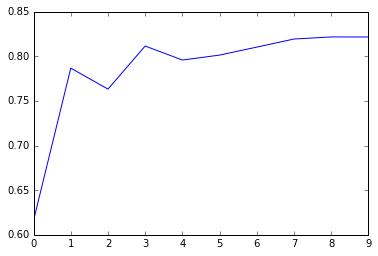

In [115]:
#print dectree.score(datax,datay)
max_depth=10
dec_score=np.zeros((max_depth))
for depth in range(max_depth):
    dectree.max_depth = depth
    dec_score[depth]=cross_validation(dectree,datax,datay,8)
plt.plot(range(max_depth),dec_score)
plt.show()
#dectree.to_pdf("tree.pdf",fields)

## NAIVE BAYES

### MODÈLE

In [123]:
class Bayes(Classifier):
    def fit(self,x,y):
        self.nb_classes=len(np.unique(y))
        x_l=np.array([x[np.where(y==i)] for i in range(self.nb_classes)])
        mean=[[np.mean(x_l[j][:,i]) for i in range(x_l[j].shape[1])] for j in range(self.nb_classes)]
        std=[[np.std(x_l[j][:,i])+.1 for i in range(x_l[j].shape[1])] for j in range(self.nb_classes)]
        self.mean=np.array(mean)
        self.std=np.array(std)
    
    def predict(self,x):
        m,s=self.mean,self.std
        maxllog=np.zeros((x.shape[0]))
        for k in range(x.shape[0]):            
            maxllog[k]=np.argmax([np.sum([np.log(1/(np.sqrt(2*np.pi)*s[j][i])*np.exp((-0.5*(float(x[k][i]-m[j][i])/s[j][i])**2))) for i in range(x.shape[1])]) for j in range(m.shape[0])])
        return maxllog

### RÉSULTATS:

In [162]:
bayes=Bayes()
cross_validation(bayes,datax,datay,8)

round 0: 0.693693693694%.
round 1: 0.81981981982%.
round 2: 0.821428571429%.
round 3: 0.738738738739%.
round 4: 0.765765765766%.
round 5: 0.794642857143%.
round 6: 0.792792792793%.
round 7: 0.741071428571%.


0.77099420849420852

## KNN

### MODÈLE

In [94]:
class KNN(Classifier):
    def __init__(self,k):
        self.k=k
        
    def fit(self,x,y):
        self.x=x
        self.y=y
        
    def predict(self,z):
        z_labels=np.zeros((len(z)))
        for index,j in enumerate(z):
            dist=np.array([np.linalg.norm(i-j) for i in self.x])
            arg_dist=np.argsort(dist)[:self.k]
            vote=self.y[arg_dist]
            z_labels[index]=np.argmax(np.bincount(vote))
        return z_labels

### RÉSULTATS:

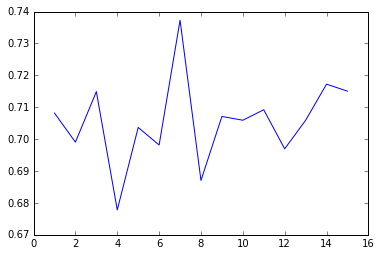

In [117]:
max_k=15
knn_score=np.zeros((max_k))
for k in range(1,max_k+1):
    knn=KNN(k=k)
    knn_score[k-1]=cross_validation(knn,datax,datay,8)
plt.plot(range(1,max_k+1),knn_score)
plt.show()

## PERCEPTRON

### MODÈLE

In [460]:
def hinge(x,y,w):
    return np.maximum(0.,-(x.dot(w))*y)

def hinge_grad(x,y,w):
    return x*y

Fonction = namedtuple("Fonction",["f","grad","dim"]) #declaration de la structure
HINGE=Fonction(hinge,hinge_grad,6)

class Perceptron(Classifier):
    def __init__(self,loss=HINGE,max_iter=100,eps=0.000001):
        self.max_iter,self.eps=max_iter,eps
        self.w=None
        self.loss=loss
        
    def fit(self,datax,datay):
        datay=v2m(datay*2-1)
        self.w=np.random.random((len(datax[0]),1))-0.5
        self.max_iter=400
        for t in range(self.max_iter):
            hinge=self.loss[0](datax,datay,self.w)
            index_pos=np.where(hinge>0.)[0]
            grad=self.loss[1](datax,datay,self.w)
            self.w+=self.eps*np.array([np.sum(grad[index_pos],axis=0)]).T
        #print 'hinge loss: '+str(np.sum(hinge))
        #print 'fit score: '+str((1.-float(len(np.where(hinge>0.)[0]))/len(datax))*100)+'%.'
        
    def predict(self,datax):
         return (np.sign(datax.dot(self.w))+1)/2

### RÉSULTATS:

In [472]:
perc=Perceptron()
new_datax=np.zeros((datax.shape[0],datax.shape[1]+3))
new_datax[:,:6]=datax
print fields
new_datax[:,6]=np.log(new_datax[:,5]*new_datax[:,5]+1)
new_datax[:,7]=np.log(new_datax[:,3]*new_datax[:,3]+1)
new_datax[:,8]=np.log(new_datax[:,0]*new_datax[:,0]+1)


print new_datax.shape,datax.shape
perc.fit(datax,datay)
perc.fit(new_datax,datay)
#perc.predict(datax[:100])
print cross_validation(perc,datax,datay,8)
print("with new params:")
print cross_validation(perc,new_datax,datay,8)

{0: 'Pclass', 1: 'Age', 2: 'Parch', 3: 'Fare', 4: 'Embarked', 5: 'Gender'}
(891, 9) (891, 6)
0.513190244311
with new params:
0.538966922141
